# Preprocess

## Env

In [4]:
%env

{'USER': 'root',
 'SSH_CLIENT': '172.23.48.1 64956 65534',
 'SHLVL': '0',
 'MOTD_SHOWN': 'pam',
 'HOME': '/root',
 'OLDPWD': '/root',
 'SSL_CERT_FILE': '/usr/lib/ssl/certs/ca-certificates.crt',
 'LOGNAME': 'root',
 '_': '/root/.vscode-server/cli/servers/Stable-fee1edb8d6d72a0ddff41e5f71a671c23ed924b9/server/node',
 'VSCODE_CLI_REQUIRE_TOKEN': '<hidden>',
 'PATH': '/bin:/root/.local/bin:/root/.vscode-server/cli/servers/Stable-fee1edb8d6d72a0ddff41e5f71a671c23ed924b9/server/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/root/.vscode-server/cli/servers/Stable-fee1edb8d6d72a0ddff41e5f71a671c23ed924b9/server/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin',
 'VSCODE_AGENT_FOLDER': '/root/.vscode-server',
 'SSL_CERT_DIR': '/usr/lib/ssl/certs',
 'LANG': 'en_US.UTF-8',
 'SHELL': '/usr/bin/zsh',
 'PWD': '/root',
 'SSH_CONNECTION': '172.23.48.1 64956 172.18.0.2 65

In [3]:
#!python -m pip install --upgrade pip
#!python -m pip install tensorflow[and-cuda]

CUDA toolkit

In [1]:
#!wget https://developer.download.nvidia.com/compute/cuda/repos/wsl-ubuntu/x86_64/cuda-keyring_1.1-1_all.deb
#!sudo dpkg -i cuda-keyring_1.1-1_all.deb
#!sudo apt-get update
#!sudo apt-get -y install cuda-toolkit-12-6

cuDNN 
https://developer.nvidia.com/cudnn-downloads?target_os=Linux&target_arch=x86_64&Distribution=Ubuntu&target_version=24.04&target_type=deb_local

In [2]:
#!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64/cuda-keyring_1.1-1_all.deb
#!sudo dpkg -i cuda-keyring_1.1-1_all.deb
#!sudo apt-get update
#!sudo apt-get -y install cudnn
#!sudo apt-get -y install cudnn-cuda-12

In [5]:
!sudo apt-get update
# Checking the GPU configuration, hardware level; drive level; CUDA level
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#!lscpu | grep NUMA


Hit:1 http://mirror.nju.edu.cn/ubuntu focal InRelease
Hit:2 http://mirror.nju.edu.cn/ubuntu focal-updates InRelease                  
Get:3 https://mirror.nju.edu.cn/adoptium/deb focal InRelease [7,511 B]         
Hit:4 http://mirror.nju.edu.cn/ubuntu focal-backports InRelease                
Hit:5 https://mirror.nju.edu.cn/docker-ce/linux/ubuntu focal InRelease         
Hit:6 http://mirror.nju.edu.cn/ubuntu focal-security InRelease      
Hit:7 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Ign:8 https://developer.download.nvidia.cn/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.cn/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 7,511 B in 2s (3,268 B/s)
Reading package lists... Done
Fri Aug 23 08:01:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.31.01              Driver Version: 560.81         CUDA Ve

2024-08-23 08:01:58.951048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2024-08-23 08:02:00.803585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.809985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.810295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
import tensorflow as tf
# GPU test
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))
    print('Tensorflow version {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
Tensorflow version 2.13.1


2024-08-23 08:02:00.825594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.825903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.826156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.968289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 08:02:00.968650: I tensorflow/compile

In [7]:
#!docker ps

## Install Lib

In [8]:
# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
#! command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
#! pip install -U -q "tf-models-official"
#! pip install mediapy remotezip

#! pip install --upgrade tensorflow tensorboard

#! pip install -i https://pypi.tuna.tsinghua.edu.cn/simple git+https://github.com/tensorflow/docs

In [11]:
import sys
print(sys.executable)
!which pip
!python -m pip install --upgrade pip
!python -m pip install pandas
!python -m pip install matplotlib
!python -m pip install scikit-image
!python -m pip install "tf-models-official"
!python -m pip install mediapy remotezip
!python -m pip install --upgrade tensorflow tensorboard
!python -m pip install --upgrade jupyter ipywidgets

/bin/python3.8
/usr/local/bin/pip


  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 294.4 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.11
    Uninstalling widgetsnbextension-4.0.11:
      Successfully uninstalled widgetsnbextension-4.0.11
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.3
    Uninstalling ipywidgets-8.1.3:
      Successfully uninstalled ipywidgets-8.1.3


## Import Lib

In [21]:
import numpy as np
import os
import datetime
import tensorflow as tf
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import random
import re

# custom functions
import csv_generator

from skimage.metrics import mean_squared_error
from matplotlib.colors import ListedColormap


from skimage.transform import resize # type: ignore
from sklearn.model_selection import train_test_split# type: ignore
from imageio import imread # type: ignore

from official.projects.movinet.modeling import movinet # type: ignore
from official.projects.movinet.modeling import movinet_model # type: ignore

seed

In [10]:
random.seed(33)
np.random.seed(33)
tf.random.set_seed(33)

## Generator
review: Range is used for generate a sequence of numbers
enumerate  is typically used in for loops when you need the index along with the element.

In [12]:
def ResizeImage(image, target_height, target_width,): # resolution following
        # Resize the image to the target dimensions
    image_resized = resize(image, (target_height, target_width), 
                           anti_aliasing=True, 
                           mode='reflect') # 'reflect' mode reflects the last few pixels at the border
    
    return image_resized


def normalizeImage(image):
    # applying normalization
    return image/255.0


def preprocessImage(image, img_height, img_width):
    return normalizeImage(ResizeImage(image, img_height, img_width))


def make3dFilter(x):
    return tuple([x]*3)


def make2dFilter(x):
    return tuple([x]*2)


def getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor):
    """
    Prepare a batch of data for training/testing.

    Parameters:
    - source_path (str): Path to the data directory.
    - shuffled_folder_list (list): List of shuffled folder names.
    - batch_idx (int): Index of the current batch.
    - batch_size (int): Number of samples in each batch.
    - imgs_tensor (tuple): Contains dimensions and indices for image processing.
    - img_idxs (list): A list of image indices to be read.
    - idx (int): the number of image indices 
    - folder_idx (int): the number of a folder (a folder is a sequence)
    Returns:
    - Tuple of (batch_data, batch_labels)  for a certain batch (eg:id = 2)
    """
    [num_imgs,img_height,img_width] = [len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2]]
    img_idxs = imgs_tensor[0]  # Assuming this is a list of image indices to be read; IMAGE INDICES, very important

    data_shape = (batch_size, num_imgs, img_height, img_width, 3) # 3 is the number of RGB channels
    batch_data = np.zeros(data_shape, dtype=np.float32) 
    batch_labels = np.zeros(data_shape, dtype=np.float32) 

    # Retrieve the folder names for the current batch from the CSV
    

    for folder_idx in range(batch_size): # a folder is a sequence
        # Load input images
        base_input_idx = folder_idx + (batch_idx * batch_size) 
        input_imgs_path = input_folder_list[base_input_idx]
        label_imgs_path = output_folder_list[base_input_idx]
        
        input_imgs = os.listdir(input_imgs_path)
        label_imgs = os.listdir(label_imgs_path)

        for idx, item in enumerate(img_idxs):

            input_img_path = os.path.join(input_imgs_path, input_imgs[item])
            label_img_path = os.path.join(label_imgs_path, label_imgs[item])
            
            img = imread(input_img_path).astype(np.float32)
            label_img = imread(label_img_path).astype(np.float32)
            for c in range(3): # For RGB channels
                batch_data[folder_idx, idx, :, :, c] = preprocessImage(img[:,:,c], img_height, img_width)
                batch_labels[folder_idx, idx, :, :, c] = preprocessImage(label_img[:,:,c], img_height, img_width)
        # Load label images (assuming similar structure and processing as input images)   
    return batch_data, batch_labels


def generator(source_path, input_folder_list, output_folder_list, batch_size, imgs_tensor):
    """
    for adjust batch size

    Parameters:
    - source_path (str): Path to the data directory.
    - input_folder_list (list): List of shuffled input folder names.
    - output_folder_list (list): List of shuffled outputput folder names.   
    - batch_size (int): Number of samples in each batch.
    - imgs_tensor (tuple): Contains dimensions and indices for image processing.

    
    Returns:
    - check get batch data
    """
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        num_batches = int(len(input_folder_list)/batch_size)
        for batch_idx in range(num_batches): #  Iterate over the number of batches
            yield getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor)        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(input_folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(input_folder_list)%batch_size # take the remainder
            yield getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor)
            
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 100, n_frames)).astype(int)
    return [img_idx, 60, 80, 3]  # dif 2 resolution's following

## Parameters

In [13]:
#curr_dt_time = datetime.datetime.now()

project_folder = '/home/linux/IHCPs'
dataset_name = '/dataset_pm1000_sin'
dataset_source_path = project_folder + dataset_name

# Load the dataset information, more details in dataset_info.csv
csv_generator.csv_generator(dataset_source_path)
dataset_info = pd.read_csv(dataset_source_path + '/dataset_info.csv')

# Shuffle the dataset
dataset_info = dataset_info.sample(frac=1).reset_index(drop=True)

# Split the dataset
train_df, val_df = train_test_split(dataset_info, test_size=0.2)

# Extract folder names for inputs and outputs (list)
train_input_folders = train_df['input_folder'].tolist()
train_output_folders = train_df['output_folder'].tolist()

val_input_folders = val_df['input_folder'].tolist()
val_output_folders = val_df['output_folder'].tolist()

# Now you have lists of folder paths for training and validation sets


# traning hyper-parameters
n_frames = 15
initial_epoch = 1
num_epochs = 100
batch_size = 2

# function part
# the number of input folders is the same as the one of output folders
num_train_sequences = len(train_input_folders)
num_val_sequences = len(val_input_folders)

# cal the step
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


imgs_tensor = getImgTensor(n_frames)
train_generator = generator(dataset_source_path, train_input_folders, train_output_folders, batch_size, imgs_tensor)
val_generator = generator(dataset_source_path, val_input_folders, val_output_folders, batch_size, imgs_tensor)


time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
InputShape = (time_steps, height, width, channels)

def print_shape(layer_name, tensor):
    print(f"{layer_name:<39} {tensor.shape}")

## Generator Validation

Here, we test the function of getImgTensor

In [15]:
# define image tensor size, test
imgs_tensor = getImgTensor(8)
print ('# imgs_tensor =', imgs_tensor)

# imgs_tensor = [array([  0,  14,  29,  43,  57,  71,  86, 100]), 60, 80, 3]


 and generator

In [14]:
sample_generator = generator(dataset_source_path, train_input_folders, train_output_folders, batch_size, imgs_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)
print(sample_batch_labels.shape)

# validation batch sample
sample_val_generator = generator(dataset_source_path, val_input_folders, val_output_folders, batch_size, imgs_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)
print(sample_val_batch_labels.shape)

Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 2


/tmp/ipykernel_1521427/3928435941.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_1521427/3928435941.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


(2, 15, 60, 80, 3)
(2, 15, 60, 80, 3)
Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 2
(2, 15, 60, 80, 3)
(2, 15, 60, 80, 3)


In [16]:
#%matplotlib inline

#for i in range(1,7):
#    fig, ax = plt.subplots()  # This creates a figure and a single subplot
#    sample_id = 4
#    ax.imshow(sample_batch_labels[sample_id, i, :, :, :])
#    ax.set_title('batch_data')

In [17]:
def plotModelHistory(h, fig_initial_value=1, save_fig=False, file_name=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    fontsize_label = 12
    keys = h.history.keys()
    
    # Plot settings: each tuple contains (training variable, validation variable, plot title)
    plot_vars = [
        ('loss', 'val_loss', "Train loss vs Validation loss"),
        ('mean_squared_error', 'val_mean_squared_error', "Train MSE vs Validation MSE")
    ]
    
    # Number of epochs
    epochs = range(fig_initial_value, fig_initial_value + len(h.history['loss']))
    
    # Iterate over the plot settings and plot each subplot
    for i, (train_var, val_var, title) in enumerate(plot_vars):
        if train_var in keys and val_var in keys:
            ax[i].semilogy(epochs, h.history[train_var], label=train_var)
            ax[i].semilogy(epochs, h.history[val_var], label=val_var)
            ax[i].legend(fontsize=fontsize_label)
            ax[i].set_title(title, fontsize=fontsize_label)
            
            # Additional settings for the subplot
            for spine in ax[i].spines.values():
                spine.set_linewidth(2)
            ax[i].tick_params(direction='in', which='both')
            ax[i].grid(which='both', linestyle='--', linewidth=0.5)
            ax[i].set_xlabel('Epoch', fontsize=fontsize_label)
            ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize_label)
        else:
            print(f"Warning: {train_var} or {val_var} not found in history keys.")

    fig.tight_layout()  # Ensure subplots do not overlap
    plt.show()
    
    # Save the figure if required
    if save_fig:
        if file_name is None:
            # Generate a default file name with a timestamp if none is provided
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            file_name = f'res_{timestamp}.png'
        fig.savefig(file_name, dpi=300)
        print(f"Figure saved as {file_name}")

    # Print max MSE values
    if 'mean_squared_error' in keys and 'val_mean_squared_error' in keys:
        print("Max. Training MSE:", max(h.history['mean_squared_error']))
        print("Max. Validation MSE:", max(h.history['val_mean_squared_error']))
    else:
        print("Warning: mean_squared_error or val_mean_squared_error not found in history keys.")
    
    # Print all history keys and values
    print("Keys:", keys)
    for key in keys:
        print(f"{key}:", h.history[key])

# Model

## Model Test

In [ ]:
inputShape = (len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2], imgs_tensor[3])
# Sequential automatch
model = tf.keras.Sequential([
    tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=inputShape, return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D()),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Convolution2DTranspose(filters=64, kernel_size=(3, 3), padding='same', activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Convolution2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Convolution2DTranspose(filters=16, kernel_size=(3, 3), padding='same', activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Convolution2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='relu')),
    # tf.keras.layers.Conv3D(3, make3dFilter(3), activation='sigmoid', padding='same', data_format='channels_last')    
], name='conv2d_lstm')


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())



## CNN+LSTM -troubled

In [ ]:
inputShape = (len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2], imgs_tensor[3])


model6 = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=inputShape)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2, 2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2, 2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), padding='same', activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), padding='same', activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), padding='same', activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2, 2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=imgs_tensor[1]*imgs_tensor[2]*imgs_tensor[3], activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=2048, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=512, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=128, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=16, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=10, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(10, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=imgs_tensor[1]*imgs_tensor[2]*imgs_tensor[3], activation='relu')),
        tf.keras.layers.Reshape(inputShape)
], name='conv_lstm')








model6.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
print(model6.summary())



## MobileNetV2   -need timedistributed, timedistributed troubled

In [ ]:
# Define the input shape
input_shape = (2, 12, 60, 80, 3)

# Create a dummy input tensor
dummy_input = tf.random.normal(input_shape)

# Define a Conv2D layer
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')

# Wrap the Conv2D layer in a TimeDistributed layer
time_distributed_layer = tf.keras.layers.TimeDistributed(conv_layer)

# Apply the TimeDistributed layer to the input tensor
conv_output = time_distributed_layer(dummy_input)

print("Input shape:", dummy_input.shape)
print("Output shape after TimeDistributed Conv2D:", conv_output.shape)

# Define a ConvLSTM2D layer
conv_lstm_layer = tf.keras.layers.ConvLSTM2D(
    filters=64, 
    kernel_size=(3, 3), 
    padding='same', 
    return_sequences=True, 
    activation='relu'
)

# Apply ConvLSTM2D to the output of TimeDistributed Conv2D
lstm_output = conv_lstm_layer(conv_output)

print("Output shape after ConvLSTM2D:", lstm_output.shape)

Input shape: (2, 12, 60, 80, 3)
Output shape after TimeDistributed Conv2D: (2, 12, 60, 80, 32)
Output shape after ConvLSTM2D: (2, 12, 60, 80, 64)


## Model 2 : Transfer Learning (MobileNetV2) with LSTM ---troubled

In [ ]:
# time_frame=len(imgs_tensor[0]), height = [1] weight = [2], channels =[3]
inputShape = (len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2], imgs_tensor[3])

# use it to extract feature
mobilenetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2 (input_shape=(imgs_tensor[1],imgs_tensor[2],imgs_tensor[3]), weights='imagenet', include_top=False) 

# Sequential automatch
model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(mobilenetV2, input_shape=inputShape),
], name='mobilenet_lstm')

for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())) # None, 12, 1280
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Reshape((1,1,1280))))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')))
#model.add(tf.keras.layers.LSTM(256, return_sequences=True))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(256,activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=imgs_tensor[1]*imgs_tensor[2]*imgs_tensor[3], activation='relu')))   
#model.add(tf.keras.layers.Reshape((inputShape)))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')))


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())

In [ ]:
# check generator
for batch_x, batch_y in train_generator:
    print(f"Train batch y shape: {batch_y.shape}")
    break
for batch_x, batch_y in val_generator:
    print(f"Validation batch y shape: {batch_y.shape}")
    break

/tmp/ipykernel_3537/3928435941.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_3537/3928435941.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


Train batch y shape: (2, 12, 60, 80, 3)
Source path =  /home/linux/IHCP_flight_pm1000/dataset ; batch size = 2
Validation batch y shape: (2, 12, 60, 80, 3)


## Test for timedistributed --failed

In [ ]:
time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
input_shape = (batch_size, time_steps, height, width, channels)




# Sequential automatch
inputs = tf.keras.Input(shape=(time_steps, height, width, channels))
print_shape("input_shape", inputs)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))(inputs)
print_shape("After Conv2D (filters=16):", x)
x = tf.keras.layers.BatchNormalization()(x)
print_shape("After BatchNormalization:", x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Conv2D (filters=32):", x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Conv2D (filters=64):", x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Conv2D (filters=64):", x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Conv2D (filters=32):", x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Conv2D (filters=16):", x)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))(x)
print_shape("After Reshape:", outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Timedistributed')

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])


print(model.summary())

input_shape                             (None, 10, 60, 80, 3)
After Conv2D (filters=16):              (None, 10, 60, 80, 16)
After BatchNormalization:               (None, 10, 60, 80, 16)
After Conv2D (filters=32):              (None, 10, 60, 80, 32)
After Conv2D (filters=64):              (None, 10, 60, 80, 64)
After Conv2D (filters=64):              (None, 10, 60, 80, 64)
After Conv2D (filters=32):              (None, 10, 60, 80, 32)
After Conv2D (filters=16):              (None, 10, 60, 80, 16)
After Reshape:                          (None, 10, 60, 80, 3)
Model: "Timedistributed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 60, 80, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 10, 60, 80, 16)    448       
 ributed)                                                        
              

2024-06-07 12:23:34.320193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:23:34.320758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:23:34.321160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:23:34.321703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:23:34.322394: I tensorflow/compile

None


2024-06-07 12:23:35.117877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-07 12:23:35.547914: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Example output shape: (4, 10, 60, 80, 3)


## 3D CNN +Conv2D--color can not change

## C3D+ConvLSTM -success

In [ ]:
time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
input_shape = (batch_size, time_steps, height, width, channels)

example_input = tf.random.normal((batch_size, time_steps, height, width, channels))





# Sequential automatch
inputs = tf.keras.Input(shape=(time_steps, height, width, channels))
print_shape("input_shape", inputs)
x = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputs)
print_shape("After Conv3D (filters=16):", x)
x = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
print_shape("After Conv3D (filters=16):", x)
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=64):", x)
x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=32):", x)
x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=16):", x)
outputs = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=3):", outputs)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='C3DConvLSTM2D')

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])


print(model.summary())

example_output = model(example_input)
print(f"Example output shape: {example_output.shape}")


input_shape                             (None, 10, 60, 80, 3)
After Conv3D (filters=16):              (None, 10, 60, 80, 16)
After Conv3D (filters=16):              (None, 10, 60, 80, 32)
After ConvLSTM2D (filters=64):          (None, 10, 60, 80, 64)
After ConvLSTM2D (filters=32):          (None, 10, 60, 80, 32)
After ConvLSTM2D (filters=16):          (None, 10, 60, 80, 16)
After ConvLSTM2D (filters=3):           (None, 10, 60, 80, 3)
Model: "C3DConvLSTM2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 60, 80, 3)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 10, 60, 80, 16)    1312      
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 80, 32)    13856     
                                                                 
 conv_lstm

## Movinet + Conv2DLSTM

### Import the MoViNet model from TensorFlow Models (tf-models-official)

In [26]:
# from official.projects.movinet.modeling import movinet_model

### Build the classifer model for buiding Backbone and loading weight

In [27]:
num_frames = n_frames
num_classes= 101
resolution = 172

model_id = 'a0'

tf.keras.backend.clear_session()
# need the pretrained model's weights, so build the model(contained backbone) first
backbone = movinet.Movinet(model_id=model_id)
pretrained_model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
pretrained_model.build([1, 1, 1, 1, 3])


# Load pretrained weights
#!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz 
#!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = 'movinet_a0_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=pretrained_model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()


In [28]:

def build_classifier(backbone, num_classes, freeze_backbone=False):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  if freeze_backbone:
    for layer in model.layers[:-1]:
      layer.trainable = False
    model.layers[-1].trainable = True

  return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.

pretrained_model = build_classifier(backbone, num_classes, freeze_backbone=True)
pretrained_model.summary()




Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [29]:
# reconstruct it in kears.model 
inputs = backbone.inputs # it's a list
outputs = backbone.output # it's a tulpe
backbone_model = tf.keras.Model(inputs=inputs, outputs=outputs)
backbone_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None, None, None,    0         []                            
                             3)]                                                                  
                                                                                                  
 stem (Stem)                 ((None, None, None, None,    248       ['inputs[0][0]']              
                             8),                                                                  
                              {})                                                                 
                                                                                                  
 block0_layer0 (MovinetBloc  ((None, None, None, None,    1721      ['stem[0][0]']            

### Test Code

In [31]:
#inputs = backbone.inputs
#print_shape("backbone inputs", backbone.inputs[0])
#outputs = backbone.outputs
#x_input = tf.keras.Input(shape=InputShape)
#print(x_input)
#print(outputs[10])
#print(backbone.outputs[10])
# Print the names and shapes of each output tensor, for find the ouput[10]
#for i, output in enumerate(backbone.outputs):
#   print(f"Output {i}: {output.name}, shape: {output.shape}")
#for i, input in enumerate(backbone.inputs):
#   print(f"Input {i}:  {input.name}, shape: {input.shape}")

### Movi-LSTM-model

In [30]:
backbone_output = backbone.outputs[10] # 
print_shape("backbone_output", backbone_output)

# static
#backbone_output_static = tf.keras.layers.Reshape((time_steps, height, width, 56))(backbone_output)
#print_shape("backbone_output_static", backbone_output_static)

# ConvLSTM2D layers to process the sequence
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', return_sequences=True)(backbone_output)


# Conv3DTranspose layers to upsample the spatial dimensions
x = tf.keras.layers.Conv3DTranspose(filters=32, kernel_size=(3, 3, 3), strides=(1, 1, 2), padding='same')(x)  
x = tf.keras.layers.Conv3DTranspose(filters=16, kernel_size=(3, 3, 3), strides=(1, 3, 2), padding='same')(x)  
x = tf.keras.layers.Conv3DTranspose(filters=16, kernel_size=(3, 3, 3), strides=(1, 5, 2), padding='same')(x) 
x = tf.keras.layers.Conv3DTranspose(filters=8, kernel_size=(3, 3, 3), strides=(1, 1, 2), padding='same')(x) 

# Final ConvLSTM2D layer to match the desired output dimensions
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', return_sequences=True)(x)
x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', return_sequences=True)(x)
x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', return_sequences=True)(x)
decoder_outputs = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', activation='relu', return_sequences=True)(x)


model = tf.keras.Model(inputs=backbone.inputs[0], outputs=decoder_outputs, name='Movi-LSTM-model')
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error', 
              metrics=['mean_squared_error']
              )





backbone_output                         (None, None, None, None, 56)
Model: "Movi-LSTM-model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None, None, None,    0         []                            
                             3)]                                                                  
                                                                                                  
 stem (Stem)                 ((None, None, None, None,    248       ['inputs[0][0]']              
                             8),                                                                  
                              {})                                                                 
                                                                                                  
 block0_layer0 

### Test shape

In [32]:
# example_input = tf.random.normal((batch_size, time_steps, height, width, channels))
# example_output = model(example_input)
# checkpoint1 = back_model(example_input)

# print_shape("Example input shape", example_input)
# print_shape("checkpoint1", checkpoint1)
# print_shape("Example output shape", example_output)



## Set up the distribution strategy

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:

# Construct loss, optimizer and compile the model
#with distribution_strategy.scope():
#  model = build_classifier(batch_size, num_frames, resolution, backbone, 10)
#  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])
     

Example output shape: (4, 10, 16, 24, 3)


## Conv2DLSTM -success


In [ ]:
# input shape
inputShape = (len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2], imgs_tensor[3])
# Sequential automatch
model = tf.keras.Sequential([
    tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=inputShape, return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
], name='Conv2DLSTM')


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())


## Conv2DLSTM -LSTM-Dense /can't predict well, reasons are unknown
## Conv2DLSTM - LSTM - Dense - Conv2DLSTM -mono color still, failed

In [ ]:
# input shape
time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
input_shape = (batch_size, time_steps, height, width, channels)

# 创建示例输入数据
example_input = tf.random.normal((batch_size, time_steps, height, width, channels))

inputs = tf.keras.Input(shape=(time_steps, height, width, channels))

# 定义格式化输出的函数
def print_shape(layer_name, tensor):
    print(f"{layer_name:<39} {tensor.shape}")

# ConvLSTM2D 层
print_shape("input_shape", inputs)
x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(inputs)
print_shape("After ConvLSTM2D (filters=16):", x)
x = tf.keras.layers.BatchNormalization()(x)
print_shape("After BatchNormalization:", x)
x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(x)
print_shape("After ConvLSTM2D (filters=32):", x)
x = tf.keras.layers.BatchNormalization()(x)
print_shape("After BatchNormalization:", x)

# LSTM 层
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)  # 展平每个时间步的特征图
print_shape("After TimeDistributed(Flatten):", x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
print_shape("After LSTM (return_sequences=True):", x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
print_shape("After LSTM (return_sequences=True):", x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
print_shape("After LSTM (return_sequences=True):", x)

# Dense 层
total_output_size = height * width * channels
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(total_output_size, activation='linear'))(x)  # 输出是 total_output_size 的向量
print_shape("After Dense:", x)

# 重塑输出以匹配输入的时间和空间维度
x = tf.keras.layers.Reshape((time_steps, height, width, channels))(x)
print_shape("After Reshape:", x)
x = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(x)
print_shape("After ConvLSTM2D (filters=3):", x)
outputs = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(x)
print_shape("After ConvLSTM2D (filters=3):", outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='ConvLSTM2D_LSTM_ConvLSTM2D-Model')

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])

# 打印模型摘要
model.summary()

# 预测示例输入数据
example_output = model(example_input)
print(f"Example output shape: {example_output.shape}")


# Model Callbacks Setup 

just like UDF, need learn more about tensorboard

In [33]:
model_name = model.name + '_' +str(datetime.datetime.now()).replace(' ','_UTC_').replace(':','_') + '/' 
print(model_name)

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{mean_squared_error:.5f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
) 

LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=4
)

# Define the Keras TensorBoard callback.
# logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint, LR]

Movi-LSTM-model_2024-08-23_UTC_08_04_57.579878/


# Training

In [35]:
%%time

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU
CPU times: user 72 µs, sys: 36 µs, total: 108 µs
Wall time: 103 µs


In [34]:
# Save model architecture
model_json = model.to_json()
with open(f"{model.name}_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [36]:
model_history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, # type: ignore
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=initial_epoch
)
# Convert history to a DataFrame
history_df = pd.DataFrame(model_history.history)

# Display the DataFrame
#print(history_df)

# Save the DataFrame to a CSV file
history_df.to_csv('training_history.csv', float_format='%.15f', index=False)

# Load the CSV file into a DataFrame
#history_df_test = pd.read_csv('training_history.csv')

Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 2


/tmp/ipykernel_1521427/3928435941.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_1521427/3928435941.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


Epoch 2/100


2024-08-23 08:05:45.589199: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa29e0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-23 08:05:45.589253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-08-23 08:05:45.614218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-08-23 08:05:45.689214: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-23 08:05:46.327461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-23 08:05:51.843334: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-23 08:05:53.224074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_u

200/200 [==============================] - ETA: 0s - loss: 26.4200 - mean_squared_error: 26.4200Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 2

Epoch 2: val_loss improved from inf to 0.02928, saving model to Movi-LSTM-model_2024-08-23_UTC_08_04_57.579878/model-00002-26.42003-26.42004.h5
200/200 [==============================] - 413s 2s/step - loss: 26.4200 - mean_squared_error: 26.4200 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 3: val_loss improved from 0.02928 to 0.02703, saving model to Movi-LSTM-model_2024-08-23_UTC_08_04_57.579878/model-00003-0.02848-0.02848.h5
200/200 [==============================] - 384s 2s/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.0283 - mean_squared_error: 0.028

# Postprocessing

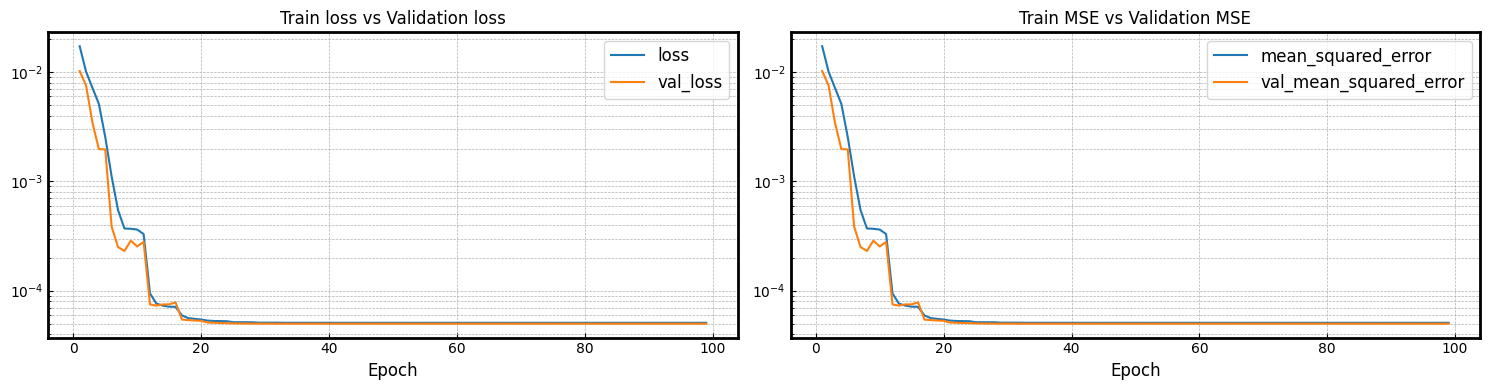

Figure saved as sin.png
Max. Training MSE: 0.017280342057347298
Max. Validation MSE: 0.010234800167381763
Keys: dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])
loss: [0.017280345782637596, 0.010094564408063889, 0.007187006063759327, 0.00512736989185214, 0.00254683755338192, 0.0011084087891504169, 0.0005464347777888179, 0.0003710516029968858, 0.0003686254203785211, 0.0003625845129135996, 0.00032997794914990664, 9.444807074032724e-05, 7.615201320732012e-05, 7.300125434994698e-05, 7.140346860978752e-05, 7.122261013137177e-05, 5.9332749515306205e-05, 5.60618718736805e-05, 5.520619379240088e-05, 5.449203308671713e-05, 5.3265881433617324e-05, 5.2805935411015525e-05, 5.267575033940375e-05, 5.2580471674446017e-05, 5.1491526392055675e-05, 5.1457191148074344e-05, 5.142781083122827e-05, 5.138294363860041e-05, 5.099745612824336e-05, 5.098724432173185e-05, 5.097813482279889e-05, 5.097540270071477e-05, 5.087148383609019e-05, 5.0866765377577394e-05, 5.08644807268

In [70]:
%matplotlib inline
# sometimes it doesn't work well, the reason is unknown
plotModelHistory(model_history, 
                 fig_initial_value=1, # type: ignore
                 save_fig=True, 
                 file_name='sin.png'
                 )
print(model_history.history.keys()) # type: ignore

Text(0.5, 1.0, 'Simple Plot 2')

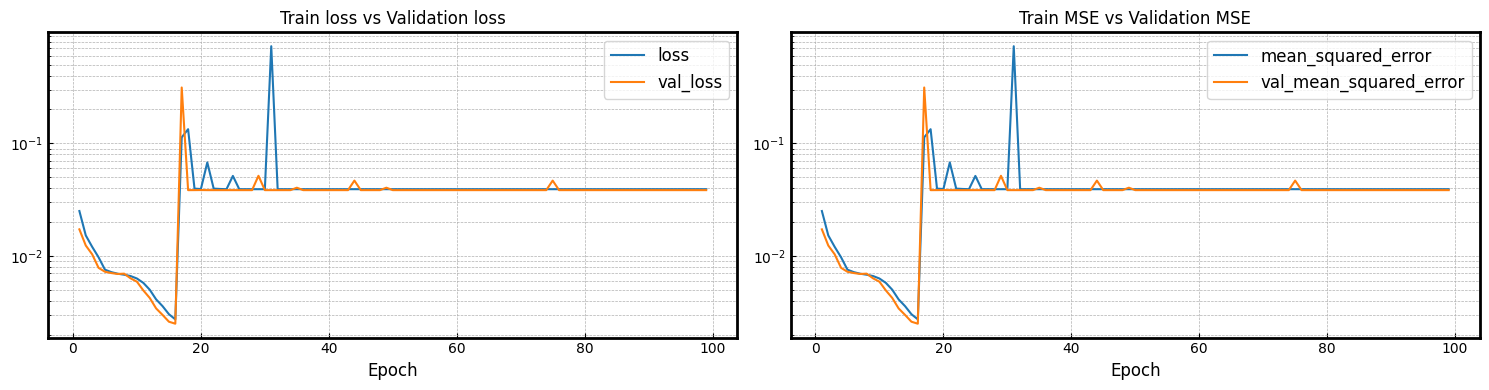

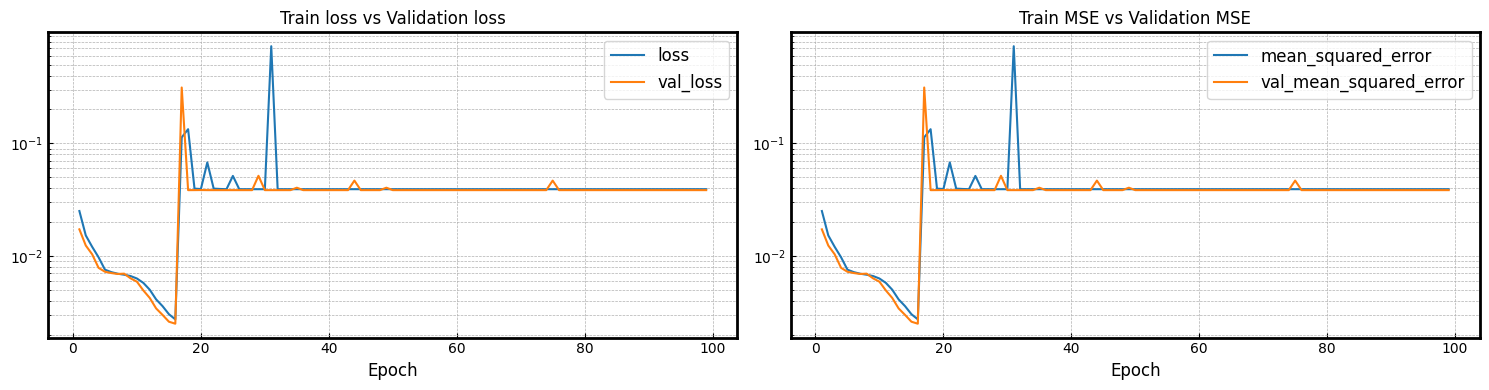

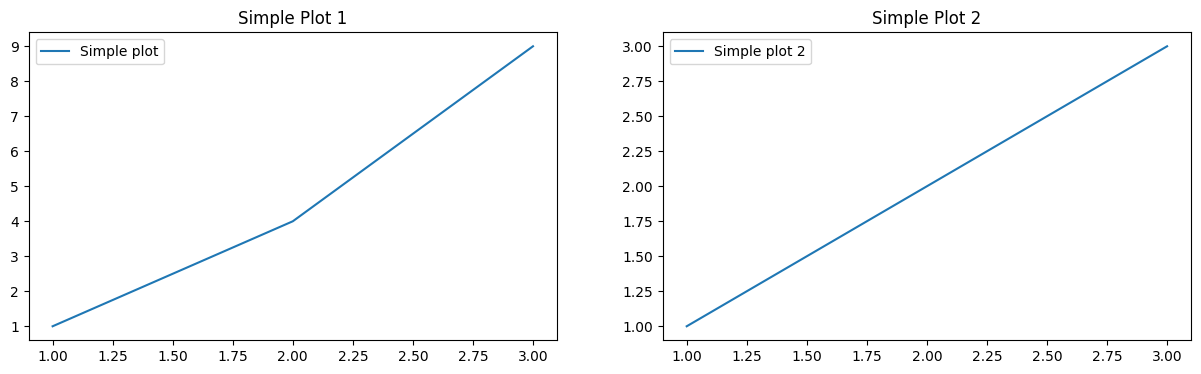

In [60]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(15, 4)) # 1 row 2 column; 15 width 4 height

ax[0].plot([1, 2, 3], [1, 4, 9], label='Simple plot')
ax[0].legend()
ax[0].set_title("Simple Plot 1")

ax[1].plot([1, 2, 3], [1, 2, 3], label='Simple plot 2')
ax[1].legend()
ax[1].set_title("Simple Plot 2")

## Test

In [65]:
# Save model architecture
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Load model architecture
with open("model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)


In [ ]:
# have problems
with open("Movi-LSTM-model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()
test_model = tf.keras.models.model_from_json(loaded_model_json)

## Compare the predictions to the ground truth

Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 1


/tmp/ipykernel_812360/3928435941.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_812360/3928435941.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


(1, 15, 60, 80, 3)


1/1 [==============================] - 7s 7s/step
prediction : (1, 15, 60, 80, 3)
prediction shape[1] -frames : 15
Predicted frame - Min value: 0.0, Max value: 0.6884490251541138
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.6677972674369812
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.6648924946784973
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.653792142868042
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.6488151550292969
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.6450167894363403
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted frame - Min value: 0.0, Max value: 0.6399611830711365
Ground Truth - Min value: 0.0, Max value: 0.6235294342041016
Predicted f

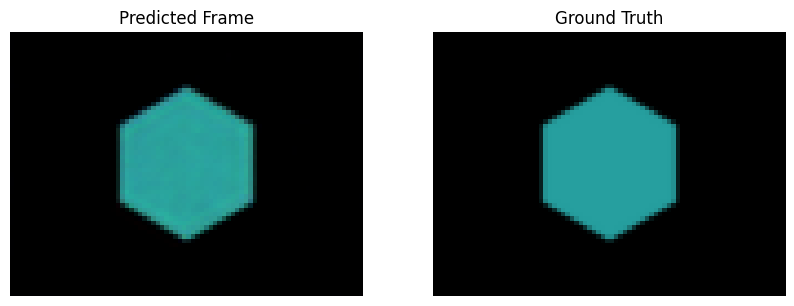

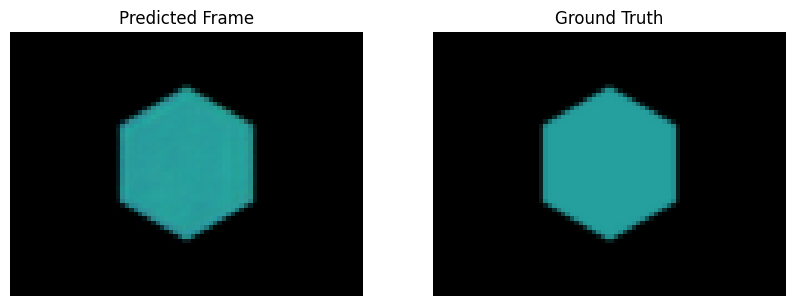

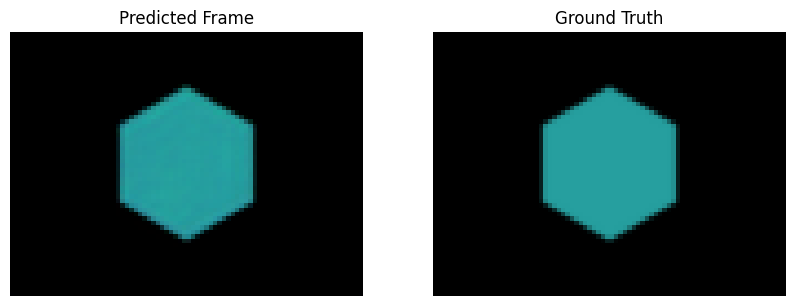

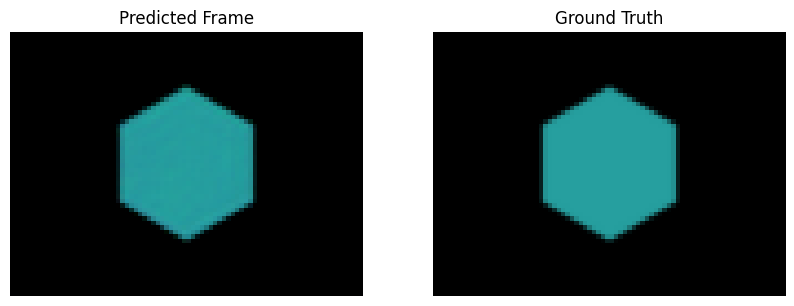

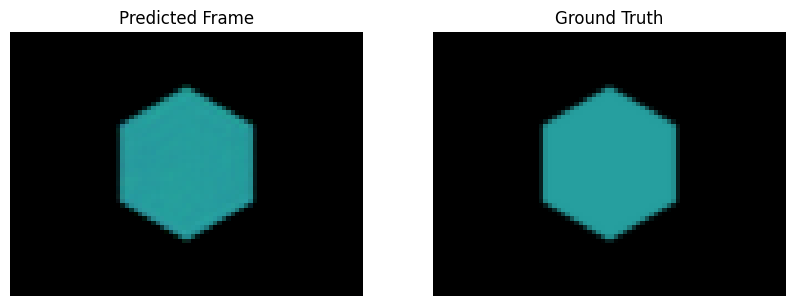

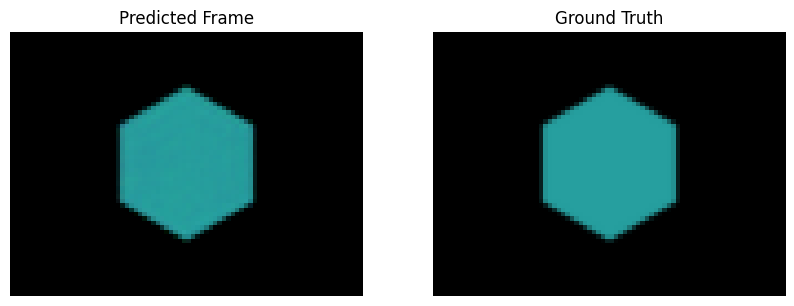

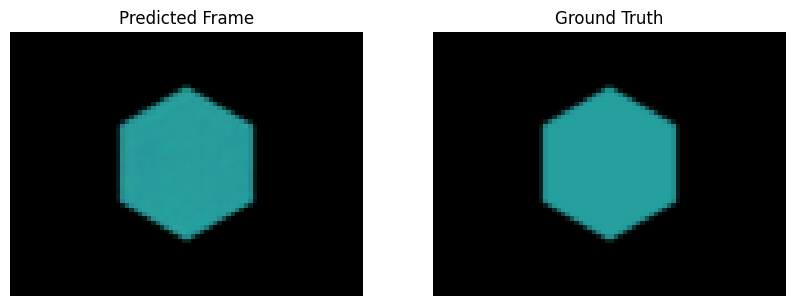

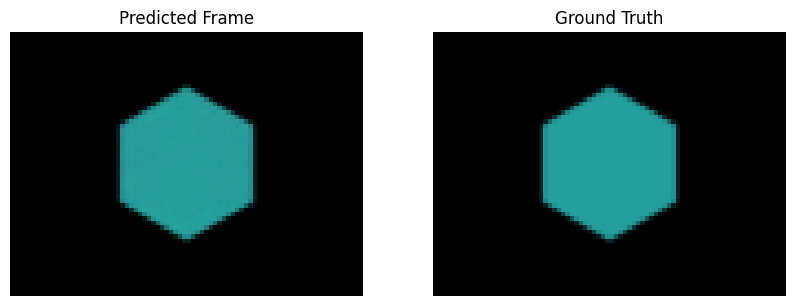

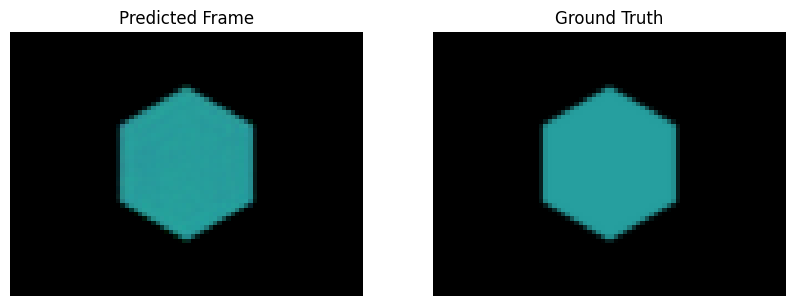

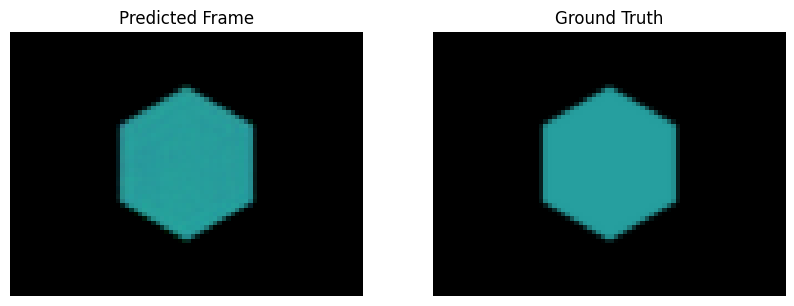

In [71]:
%matplotlib inline
test_model = model

test_model.load_weights('/home/linux/IHCPs/Movi-LSTM-model_2024-08-22_UTC_08_11_31.146597/model-00056-0.00005-0.00005.h5') # type: ignore

test_batch_size = 1
imgs_tensor = getImgTensor(n_frames)


# testing batch sample
sample_test_generator = generator(dataset_source_path, val_input_folders, val_output_folders, test_batch_size, imgs_tensor)

sample_test_batch_data, sample_test_batch_labels = next(sample_test_generator)


print(sample_test_batch_data.shape)

# and use the sample_test_batch data
prediction = test_model.predict(sample_test_batch_data) 
print(f'prediction : {prediction.shape}')
print(f'prediction shape[1] -frames : {prediction.shape[1]}')

for i in range(min(10, prediction.shape[1])):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(prediction[0][i], interpolation='antialiased')
    plt.title("Predicted Frame")
    plt.axis('off')  

    plt.subplot(1, 2, 2)
    plt.imshow(sample_test_batch_labels[0][i], interpolation='antialiased')
    plt.title('Ground Truth')
    plt.axis('off')
    min_pred_value = prediction[0][i].min()
    max_pred_value = prediction[0][i].max()
    min_gt_value = sample_test_batch_labels[0][i].min()
    max_gt_value = sample_test_batch_labels[0][i].max()
    print(f'Predicted frame - Min value: {min_pred_value}, Max value: {max_pred_value}')
    print(f'Ground Truth - Min value: {min_gt_value}, Max value: {max_gt_value}')

    #plt.savefig(f'{project_folder}/result/output{i}', bbox_inches='tight', pad_inches=0)




In [36]:

print(f'Predicted frame shape: {prediction[0][i].shape}')


Predicted frame shape: (60, 80, 3)


## test specific case

In [72]:
# based on the target values, find the closest filenames

data_csv = pd.read_csv(project_folder + dataset_name + '/dataset_info.csv')

# Split the folder_name into number and value, and extract value as float
data_csv['value'] = data_csv['folder_name'].apply(lambda x: float(x.split('_')[1]))

# target value
target_values = [7e5, 4e5, 2.75e5, 1.89e5, 1.45e5, 
                 1.30E+06, 7.40E+05, 4.75E+05, 3.68E+05, 2.89E+05]

# Initialize a list to hold the closest filenames
closest_filenames = []

# Loop through the target values only once to compute the differences
for target_value in target_values:
    data_csv['diff'] = abs(data_csv['value'] - target_value)
    closest_filename = data_csv.loc[data_csv['diff'].idxmin(), 'folder_name']
    closest_filenames.append(closest_filename)
    print(closest_filename)

115A_700446.4105
466A_398699.6054
415A_270524.7569
80A_191034.9683
245A_145195.8646
419A_1300027.6277
266A_742080.8436
146A_476937.4163
44A_366782.1699
166A_295298.5904


### show batch_data and batch_label

In [73]:
groundtruth_heatflux = [float(re.search(r'_(\d+\.\d+)$', item).group(1)) for item in closest_filenames] # type: ignore
print(groundtruth_heatflux)

closest_filename_index = 5
specific_folder_name = closest_filenames[closest_filename_index]
print(specific_folder_name)
specific_input_folder_path = project_folder + dataset_name + '/input/' + specific_folder_name
specific_output_folder_path = project_folder + dataset_name + '/output/' + specific_folder_name

# now, these paths contain only one folder
input_folders_list = [specific_input_folder_path]
output_folders_list = [specific_output_folder_path]


# use generator function to get the specific batch data
specific_generator = generator(dataset_source_path, input_folders_list, output_folders_list, test_batch_size, imgs_tensor)

specific_batch_data, specific_batch_labels = next(specific_generator)

print(specific_batch_data.shape)
prediction = test_model.predict(specific_batch_data)
print(prediction.shape)



[700446.4105, 398699.6054, 270524.7569, 191034.9683, 145195.8646, 1300027.6277, 742080.8436, 476937.4163, 366782.1699, 295298.5904]
419A_1300027.6277
Source path =  /home/linux/IHCPs/dataset_pm1000_sin ; batch size = 1


/tmp/ipykernel_812360/3928435941.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_812360/3928435941.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


(1, 15, 60, 80, 3)
1/1 [==============================] - 0s 225ms/step


(1, 15, 60, 80, 3)


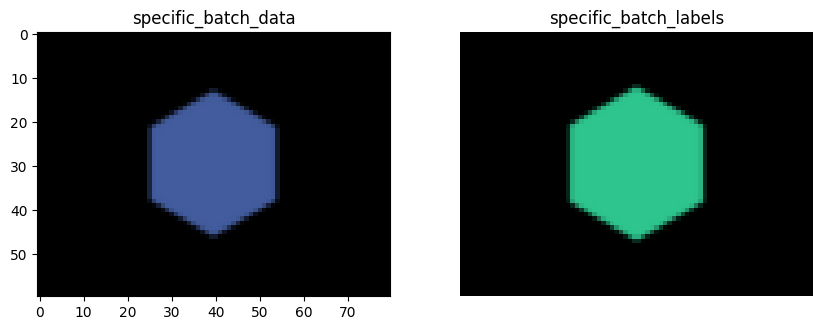

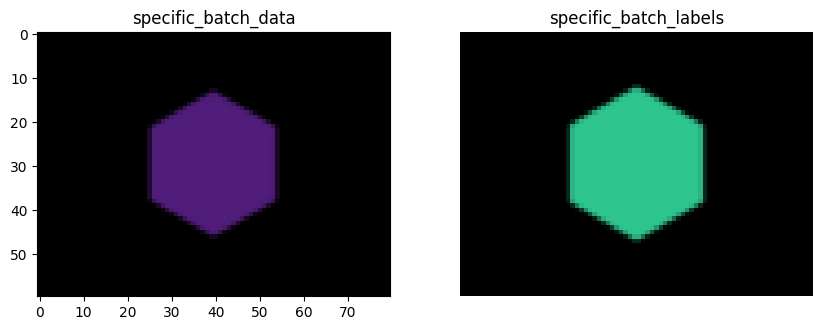

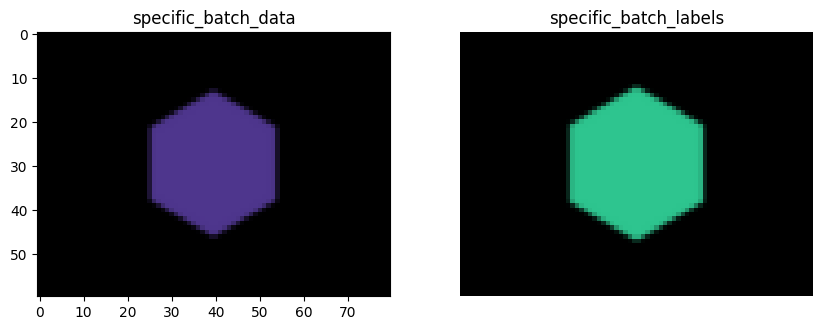

In [49]:
# show data
for i in range(min(3, prediction.shape[1])): # shape[1] = frame
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(specific_batch_data[0][i], interpolation='antialiased')
    plt.title("specific_batch_data")

    plt.subplot(1, 2, 2)
    plt.imshow(specific_batch_labels[0][i], interpolation='antialiased')
    plt.title('specific_batch_labels')
    plt.axis('off')

### prediction and batch_label

In [ ]:
# generate fig for test result
for i in range(min(10, prediction.shape[1])):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(prediction[0][i], interpolation='antialiased')
    plt.title("Predicted Frame")
    plt.axis('off')  

    plt.subplot(1, 2, 2)
    plt.imshow(specific_batch_labels[0][i], interpolation='antialiased')
    plt.title('Ground Truth')
    plt.axis('off')


    # saving data
    #fig_path = project_folder + f'/result/output{i}'
    #plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    # plt.close()  # Close the figure to prevent it from displaying


### heatflux&time

In [45]:
# Function to find the closest scalar value for a given color
def find_closest_scalar(color, df):
    distances = np.linalg.norm(df[['Red', 'Green', 'Blue']].values - np.array(color[:3]), axis=1)
    closest_index = np.argmin(distances)
    return df.loc[closest_index, 'Scalar']


# Encapsulated function
def find_and_plot_closest_scalar(data, scalar_color_map, frame_index=0, roi_size=20, show_image=True):
    # Set the test point (x, y)
    center_x, center_y = data.shape[3] // 2, data.shape[2] // 2


    # Define the ROI (Region of Interest), last number is not included
    data_batch_size = 0
    half_size = roi_size // 2
    roi = data[data_batch_size, frame_index, center_y - half_size:center_y + half_size + 1, center_x - half_size:center_x + half_size + 1, :3]


    # Calculate the average color in the ROI
    average_color = np.mean(roi, axis=(0, 1))

    # Normalize the average color if necessary
    if average_color.max() > 1:
        average_color = average_color / 255.0

    # Append alpha value 255 to the average color
    average_color = np.append(average_color, 255)

    # Find the closest scalar value for the center color
    closest_scalar = find_closest_scalar(average_color, scalar_color_map)

    print(f"The closest scalar value for the center color {average_color} is {closest_scalar}")


    # Plot the frame
    if show_image:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(data[0, frame_index])
        plt.title(f"Frame {frame_index}")
        plt.axis('off')
        plt.show()

    return closest_scalar

#### Dataframe-from image

In [54]:
from PIL import Image
# Read the new colormap image file and convert it to a numpy array
new_image_path = '/home/linux/IHCPs/colorbar.png'  # Replace this path with your image path
new_image = Image.open(new_image_path)
new_image_array = np.array(new_image)  # (height, width, channels, alpha)

# Extract the color strip (here we extract a vertical line, assumed to be in the middle of the image)
strip_x_start = new_image_array.shape[1] // 2
color_strip = new_image_array[:, strip_x_start, :]  # Extracting a single column

# Get the height of the color strip
strip_height = color_strip.shape[0]

print(f'Original color strip shape: {color_strip.shape}')

# Sample colors
#sample_points = int(2e6 - 1e5) + 1
#sample_indices = np.linspace(0, strip_height - 1, sample_points).astype(int)
#sample_colors = color_strip[sample_indices, :]

# Use all pixels for sampling
sample_colors = color_strip

# Reverse the order of sampled colors to match scalar values
sample_colors = sample_colors[::-1]


# Separate RGB and alpha channels
rgb_colors = sample_colors[:, :3]  # Extracting RGB channels
if sample_colors.shape[1] == 4:
    alpha_channel = sample_colors[:, 3]  # Extracting alpha channel if it exists
else:
    alpha_channel = np.full(sample_colors.shape[0], 255)  # Set alpha to 255 for full opacity

# Normalize sampled colors if they are not already normalized
if rgb_colors.max() > 1:
    rgb_colors = rgb_colors / 255.0

# Recombine RGB and alpha channels
sample_colors = np.concatenate((rgb_colors, alpha_channel[:, None]), axis=1)

# Generate scalar values (range adjusted from 1e5 to 2e6)
scalar_values = np.linspace(1e5, 2e6, strip_height)

# Create (scalar value, color) table
scalar_color_map = list(zip(scalar_values, sample_colors))

# Consolidate scalar_color_map to have unique colors
consolidated_map = {}
for scalar, color in scalar_color_map:
    color_tuple = tuple(color)
    if color_tuple in consolidated_map:
        consolidated_map[color_tuple].append(scalar)
    else:
        consolidated_map[color_tuple] = [scalar]

# Choose a representative scalar value for each unique color
unique_scalar_color_map = [(np.mean(scalars), list(color)) for color, scalars in consolidated_map.items()]

# Convert unique_scalar_color_map to DataFrame for verification
df_heatcameralight = pd.DataFrame(unique_scalar_color_map, columns=['Scalar', 'Color'])


df_heatcameralight[['Red', 'Green', 'Blue', 'Alpha']] = pd.DataFrame(df_heatcameralight['Color'].tolist(), index=df_heatcameralight.index)
df_heatcameralight = df_heatcameralight.drop(columns=['Color'])

# Visualize the result
# plt.figure(figsize=(2, 10))
# plt.imshow(color_strip.reshape(strip_height, 1, 4))  # Correctly reshape for visualization
# plt.axis('off')
# plt.show()

Original color strip shape: (556, 4)


#### dataframe-viridis

In [44]:
# Define the range of scalar values
scalar_values = np.linspace(1e5, 2e6, 1000)

# Normalize scalar values to range between 0 and 1 for colormap
norm_scalar_values = (scalar_values - scalar_values.min()) / (scalar_values.max() - scalar_values.min())

# Get the viridis colormap from matplotlib
viridis_cmap = plt.get_cmap('viridis') # type: ignore

# Create colors by mapping normalized scalar values within the colormap
colors = viridis_cmap(norm_scalar_values)

# Create a DataFrame with scalar values and their corresponding colors
df_viridis = pd.DataFrame({
    'Scalar': scalar_values,
    'Red': colors[:, 0],
    'Green': colors[:, 1],
    'Blue': colors[:, 2],
    'Alpha': colors[:, 3]
})

# Remove duplicate colors while averaging the Scalar values
viridis_unique = df_viridis.groupby(['Red', 'Green', 'Blue', 'Alpha'], as_index=False).min()


# Print the number of unique colors
print(f'Number of unique colors: {len(viridis_unique)}')



Number of unique colors: 256


#### generate colormap

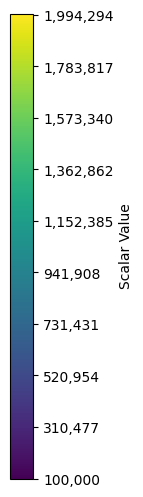

In [47]:

# Assuming df is already defined and contains scalar and color data
# df = pd.DataFrame(...)

# Extract scalar values and colors from DataFrame
scalar_values =  viridis_unique['Scalar'].values

colors = np.array(viridis_unique[['Red', 'Green', 'Blue']].values)

# Normalize only the alpha channel

# Create a custom colormap
cmap = ListedColormap(colors) # type: ignore

# Create a figure object
fig, ax = plt.subplots(figsize=(2, 10))

# Create a ScalarMappable object for the color bar
norm = plt.Normalize(vmin=1e5, vmax=2e6) # type: ignore
sm = plt.cm.ScalarMappable(cmap=viridis_cmap, norm=norm) # type: ignore
sm.set_array([])

# Add the color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')

# Set the ticks and tick labels
num_ticks = 10
tick_locs = np.linspace(scalar_values.min(), scalar_values.max(), num_ticks) # type: ignore
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([f'{int(t):,}' for t in tick_locs])  # Format labels with commas

# Ensure labels are correctly placed by using rotation and alignment
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

# Set the color bar label
cbar.set_label('Scalar Value')

# Remove axis ticks and labels
ax.remove()

# Show the figure
plt.show()


In [48]:
print(viridis_unique.head())  # Print the first few rows of the DataFrame to inspect values

# Check the unique colors and their corresponding scalar values
for i, row in viridis_unique.iterrows():
    print(f"Scalar: {row['Scalar']}, Color: ({row['Red']}, {row['Green']}, {row['Blue']}, {row['Alpha']})")

        Red     Green      Blue  Alpha        Scalar
0  0.119423  0.611141  0.538982    1.0  1.140340e+06
1  0.119483  0.614817  0.537692    1.0  1.147948e+06
2  0.119512  0.607464  0.540218    1.0  1.132733e+06
3  0.119699  0.618490  0.536347    1.0  1.155556e+06
4  0.119738  0.603785  0.541400    1.0  1.125125e+06
Scalar: 1140340.3403403405, Color: (0.119423, 0.611141, 0.538982, 1.0)
Scalar: 1147947.947947948, Color: (0.119483, 0.614817, 0.537692, 1.0)
Scalar: 1132732.7327327328, Color: (0.119512, 0.607464, 0.540218, 1.0)
Scalar: 1155555.5555555555, Color: (0.119699, 0.61849, 0.536347, 1.0)
Scalar: 1125125.125125125, Color: (0.119738, 0.603785, 0.5414, 1.0)
Scalar: 1163163.1631631632, Color: (0.120081, 0.622161, 0.534946, 1.0)
Scalar: 1117517.5175175176, Color: (0.120092, 0.600104, 0.54253, 1.0)
Scalar: 1109909.90990991, Color: (0.120565, 0.596422, 0.543611, 1.0)
Scalar: 1168868.8688688688, Color: (0.120638, 0.625828, 0.533488, 1.0)
Scalar: 1102302.3023023023, Color: (0.121148, 0.592

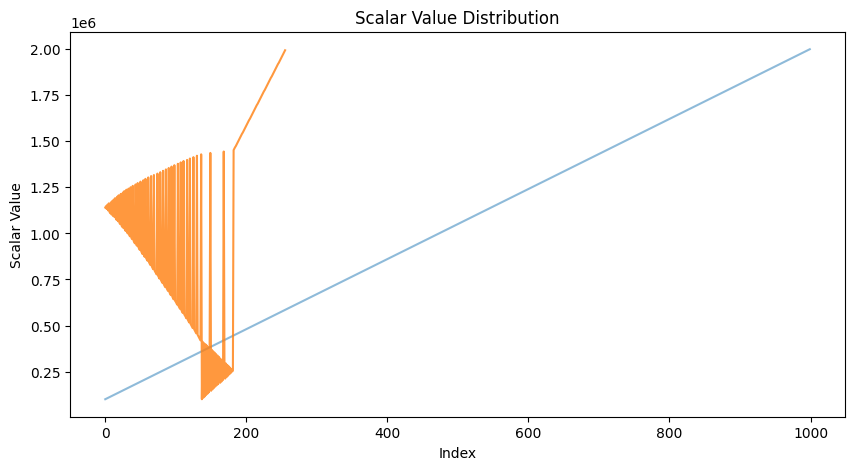

In [49]:
# Plot the scalar values to check their distribution
plt.figure(figsize=(10, 5))
plt.plot(df_viridis['Scalar'].values, label='Original Scalar Values', alpha=0.5)
plt.plot(viridis_unique['Scalar'].values, label='Deduplicated Scalar Values', alpha=0.8)
plt.title('Scalar Value Distribution')
plt.xlabel('Index')
plt.ylabel('Scalar Value')
plt.show()

#### DataFrame finished

#### MSE MAE ME

In [52]:
def calculate_errors_single_frame(prediction, ground_truth, batch_index, frame_index):
    predicted_frame = prediction[batch_index, frame_index]
    ground_truth_frame = ground_truth[batch_index, frame_index]
    
    # Mean Squared Error
    mse = mean_squared_error(ground_truth_frame, predicted_frame)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(ground_truth_frame - predicted_frame))

    # Mean Error Percentage, black is (0,0,0)
    #me_p = np.mean(
    #np.where(ground_truth_frame != 0, 
    #         (predicted_frame - ground_truth_frame) / ground_truth_frame, 
    #         0)
    #
    #print(np.mean(predicted_frame - ground_truth_frame))
    #print(np.mean(ground_truth_frame))
    ratio = np.mean(predicted_frame) / np.mean(ground_truth_frame)
    me_p = ratio - 1    
    #print(me_p)
    #me_p = np.mean((predicted_frame - ground_truth_frame) / (ground_truth_frame + 1e-10))
    
    # Calculate the mask for non-black pixels
    #mask = np.all(ground_truth_frame != [0, 0, 0], axis=-1)

    #me_p = np.mean(predicted_frame[mask] - ground_truth_frame[mask])
   

    return mse, mae, me_p

# Example usage:
# Assuming prediction and ground_truth are numpy arrays of shape (batch_size, num_frames, height, width, RGB_channels)

mse, mae, me_p = calculate_errors_single_frame(prediction, specific_batch_labels, batch_index=0, frame_index=2)

print("MSE:", mse)
print("MAE:", mae)
print("ME%:", me_p * 100 , '%')



MSE: 2.0117633725442075e-05
MAE: 0.0015947104
ME%: -0.30458569526672363 %


In [53]:
print(specific_batch_labels.shape)
print(prediction.shape)

(1, 10, 60, 80, 3)
(1, 10, 60, 80, 3)


#### now input color, output heatflux

In [54]:
# Initialize lists to hold results


x_frames = []
cal_prediction_heatflux_values = []
groundtruth_heatflux_values = []
error_values= []

A = groundtruth_heatflux[closest_filename_index]
print(f'the value of A is {A}')
true_value_test =A * np.sin(((np.pi * 30) / 30) - np.pi / 2) + A
print(f'true value is {true_value_test}')
time_points = getImgTensor(n_frames)[0]
print(A)
#print(f'the value of t is {time_points}')
#print(len(time_points))

for frame_index in range(prediction.shape[1]):
    #value1 = find_and_plot_closest_scalar(prediction, viridis_unique, frame_index=frame_index, show_image=False)
    #value2 = find_and_plot_closest_scalar(specific_batch_labels, viridis_unique, frame_index=frame_index, show_image=False)
    #error_value = (value1 - value2) / value2

    # Calculate the errors for the current frame based on the color deviation
    mse, mae, me_p = calculate_errors_single_frame(prediction, specific_batch_labels, batch_index=0, frame_index=frame_index) # type: ignore

    print("MSE:", mse)
    print("MAE:", mae)
    print("ME_p:", me_p)

    # just for constant value, for each frame, we need different value, so we need to change the function
    true_value = groundtruth_heatflux[closest_filename_index]

    time_point = time_points[frame_index]
    # just for sin function
    #true_value =A * np.sin(((np.pi * time_point+1) / 30) - np.pi / 2) + A


    print(f'true value is {true_value}')

    delta_value = me_p * true_value
    print(f'delta value is {delta_value}')

    cal_prediction_heatflux = delta_value + true_value
    print(f'cal_prediction_heatflux is {cal_prediction_heatflux}')

    # Store the results for plotting
    x_frames.append(frame_index)
    cal_prediction_heatflux_values.append(cal_prediction_heatflux)
    groundtruth_heatflux_values.append(true_value)
    #error_values.append(error_value)
    
    #print(f'the error is {error_value}')
    print(f'groundtruth_heatflux is {groundtruth_heatflux[closest_filename_index]}')
    print(f'cal_prediction_heatflux is {cal_prediction_heatflux}')

    print("MSE:", mse)
    print("MAE:", mae)
    print("Mean Error (ME):", me_p * 100)



the value of A is 1300027.6277
true value is 2600055.2554
1300027.6277
MSE: 5.08332157586087e-05
MAE: 0.0024415606
ME_p: 0.001793503761291504
true value is 1300027.6277
delta value is 2331.604440062821
cal_prediction_heatflux is 1302359.2321400628
groundtruth_heatflux is 1300027.6277
cal_prediction_heatflux is 1302359.2321400628
MSE: 5.08332157586087e-05
MAE: 0.0024415606
Mean Error (ME): 0.1793503761291504
MSE: 2.4377862745540347e-05
MAE: 0.0017474238
ME_p: 0.00019061565399169922
true value is 1300027.6277
delta value is 247.80561646131278
cal_prediction_heatflux is 1300275.4333164613
groundtruth_heatflux is 1300027.6277
cal_prediction_heatflux is 1300275.4333164613
MSE: 2.4377862745540347e-05
MAE: 0.0017474238
Mean Error (ME): 0.019061565399169922
MSE: 2.0117633725442075e-05
MAE: 0.0015947104
ME_p: -0.0030458569526672363
true value is 1300027.6277
delta value is -3959.6981884895386
cal_prediction_heatflux is 1296067.9295115105
groundtruth_heatflux is 1300027.6277
cal_prediction_heatf

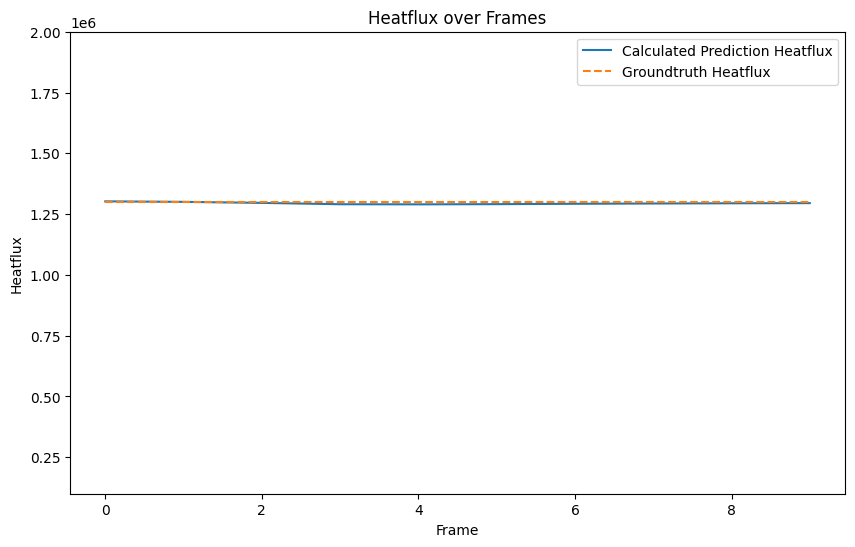

In [55]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_frames, cal_prediction_heatflux_values, label='Calculated Prediction Heatflux')
plt.plot(x_frames, groundtruth_heatflux_values, label='Groundtruth Heatflux', linestyle='--')
plt.xlabel('Frame')
plt.ylabel('Heatflux')
plt.title('Heatflux over Frames')
plt.legend()

# Set the y-axis limits
plt.ylim(1e5, 2e6)  # Adjust the y-axis limits as needed


plt.show()

In [56]:
# Outputdata
# Create a dictionary with your data
data = {
    'Frame': x_frames,
    'Calculated Prediction Heatflux': cal_prediction_heatflux_values,
    'Groundtruth Heatflux': groundtruth_heatflux_values
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Optionally, you can save this DataFrame to a CSV file
df.to_csv('heatflux_over_frames.csv', index=False)

   Frame  Calculated Prediction Heatflux  Groundtruth Heatflux
0      0                    1.302359e+06          1.300028e+06
1      1                    1.300275e+06          1.300028e+06
2      2                    1.296068e+06          1.300028e+06
3      3                    1.290531e+06          1.300028e+06
4      4                    1.290065e+06          1.300028e+06
5      5                    1.290862e+06          1.300028e+06
6      6                    1.292375e+06          1.300028e+06
7      7                    1.293569e+06          1.300028e+06
8      8                    1.294471e+06          1.300028e+06
9      9                    1.295131e+06          1.300028e+06


## TensorBoard

In [46]:
# Step 1: Create and train the model
import tensorflow as tf

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

model111 = create_model()

log_dir = "logs/test"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model111.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

# Step 2: Load TensorBoard extension and start TensorBoard
%reload_ext tensorboard
%tensorboard --logdir logs/test --port 6006


Epoch 1/5


2024-06-14 08:52:01.951234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1875/1875 [==============================] - 9s 4ms/step - loss: 0.2614 - accuracy: 0.9245 - val_loss: 0.1602 - val_accuracy: 0.9521
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1168 - accuracy: 0.9656 - val_loss: 0.1007 - val_accuracy: 0.9672
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0798 - accuracy: 0.9762 - val_loss: 0.0853 - val_accuracy: 0.9734
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0603 - accuracy: 0.9819 - val_loss: 0.0870 - val_accuracy: 0.9724
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.0816 - val_accuracy: 0.9753
